------

# **Smart Routes Madrid**

## **Project Aim**

The primary aim of this project is to deeply understand and effectively manage traffic conditions in Madrid. By analyzing the distribution of traffic intensity, I want to identify patterns and anomalies in traffic flow across different times of the day, under various weather conditions, and over longitudinal trends. This will include:

1. **Hourly Analysis**: Breaking down traffic intensity by hours within each day type to identify peak hours.

2. **Impact of Weather**: Investigating how different weather conditions affect traffic intensity on various day types.
3. **Longitudinal Trends**: Examining how traffic patterns have evolved over the years to detect shifts in commuter behavior and the impact of new or modified infrastructure.

By focusing on these areas, this project aims to develop a comprehensive understanding of traffic dynamics that can support more informed decisions, targeted interventions, and proactive traffic management in Madrid.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gdp
import geodatasets
import folium
from shapely.geometry import Point

from concurrent.futures import ProcessPoolExecutor
from ydata_profiling import ProfileReport
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

import warnings
warnings.filterwarnings('ignore')



------

## 2. Exploration and cleaning of the dataset

### 2.1. Exploration of the dataset





In [ ]:
# Loading dataset

smart_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/smart-routes-madrid/TrafficDator_Madrid.csv')
smart_data.head()

id                 date  longitude   latitude  traffic_intensity  \
0  3421  2022-06-01 00:00:00  -3.690586  40.465693             301.50   
1  3421  2022-06-01 01:00:00  -3.690586  40.465693             162.50   
2  3421  2022-06-01 02:00:00  -3.690586  40.465693             109.75   
3  3421  2022-06-01 03:00:00  -3.690586  40.465693              72.00   
4  3421  2022-06-01 04:00:00  -3.690586  40.465693              94.75   

      day_type  wind  temperature  precipitation  \
0  Working day  1.75         18.1            0.0   
1  Working day  1.75         18.1            0.0   
2  Working day  1.75         18.1            0.0   
3  Working day  1.75         18.1            0.0   
4  Working day  1.75         18.1            0.0   

                               original_point                  closest_point  \
0  POINT (-3.69058588014246 40.4656926663558)  POINT (-3.6905835 40.4656912)   
1  POINT (-3.69058588014246 40.4656926663558)  POINT (-3.6905835 40.4656912)   
2  POINT (-3.69058588014246 40.4656926663558)  POINT (-3.6905835 40.4656912)   
3  POINT (-3.69058588014246 40.4656926663558)  POINT (-3.6905835 40.4656912)   
4  POINT (-3.69058588014246 40.4656926663558)  POINT (-3.6905835 40.4656912)   

   oneway  lanes                    name    highway  maxspeed   length  
0    True    2.0  Calle de Bravo Murillo  secondary      50.0  159.569  
1    True    2.0  Calle de Bravo Murillo  secondary      50.0  159.569  
2    True    2.0  Calle de Bravo Murillo  secondary      50.0  159.569  
3    True    2.0  Calle de Bravo Murillo  secondary      50.0  159.569  
4    True    2.0  Calle de Bravo Murillo  secondary      50.0  159.569

-----


In [ ]:
smart_data.shape

(3467635, 17)

* __3467635__ Rows

* __17__ Columns
---

In [ ]:
smart_data.columns

Index(['id', 'date', 'longitude', 'latitude', 'traffic_intensity', 'day_type',
       'wind', 'temperature', 'precipitation', 'original_point',
       'closest_point', 'oneway', 'lanes', 'name', 'highway', 'maxspeed',
       'length'],
      dtype='object')

----

In [ ]:
smart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467635 entries, 0 to 3467634
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 int64  
 1   date               object 
 2   longitude          float64
 3   latitude           float64
 4   traffic_intensity  float64
 5   day_type           object 
 6   wind               float64
 7   temperature        float64
 8   precipitation      float64
 9   original_point     object 
 10  closest_point      object 
 11  oneway             bool   
 12  lanes              float64
 13  name               object 
 14  highway            object 
 15  maxspeed           float64
 16  length             float64
dtypes: bool(1), float64(9), int64(1), object(6)
memory usage: 426.6+ MB


In [ ]:
# Check for missing values
smart_data.isna().sum()

id                   0
date                 0
longitude            0
latitude             0
traffic_intensity    0
day_type             0
wind                 0
temperature          0
precipitation        0
original_point       0
closest_point        0
oneway               0
lanes                0
name                 0
highway              0
maxspeed             0
length               0
dtype: int64

* There's no existence of NaN values in this Dataset
---

In [ ]:
print(smart_data['day_type'].value_counts())

day_type
Working day    2833654
Sunday          491558
Holiday         113833
Saturday         28590
Name: count, dtype: int64


# **Some insights**

- **Working Days Dominance**: The dataset primarily consists of 'Working day' entries (2,833,654), indicating a higher frequency of data collection or activities on these days compared to non-working days.
  
- **Weekend and Holiday Rarity**: The counts for Sundays (491,558), Holidays (113,833), and especially Saturdays (28,590) are significantly lower than for working days, suggesting less activity or fewer events occur on these days or possibly issues in data collection.

- **Utility in Time Series and Behavioral Analysis**: The variation in day counts offers a valuable opportunity for time series analysis to explore how behaviors or other variables change between working and non-working days.

-----

In [ ]:
smart_data__range = pd.to_datetime(smart_data['date']).agg(['min', 'max'])

smart_data__range

min   2022-06-01 00:00:00
max   2023-09-30 23:00:00
Name: date, dtype: datetime64[ns]

* Date ranges from the 1st June 2022 to the 30th September of the year 2023
---

In [ ]:
smart_data.describe(include='all')

id                 date     longitude      latitude  \
count   3.467635e+06              3467635  3.467635e+06  3.467635e+06   
unique           NaN                11688           NaN           NaN   
top              NaN  2023-04-05 15:00:00           NaN           NaN   
freq             NaN                  300           NaN           NaN   
mean    5.772925e+03                  NaN -3.689573e+00  4.043193e+01   
std     2.042748e+03                  NaN  4.044128e-02  3.623017e-02   
min     3.421000e+03                  NaN -3.836886e+00  4.033639e+01   
25%     4.305000e+03                  NaN -3.711309e+00  4.040661e+01   
50%     5.271000e+03                  NaN -3.692052e+00  4.043208e+01   
75%     6.298000e+03                  NaN -3.666773e+00  4.045755e+01   
max     1.089300e+04                  NaN -3.600391e+00  4.051293e+01   

        traffic_intensity     day_type          wind   temperature  \
count        3.467635e+06      3467635  3.467635e+06  3.467635e+06   
unique                NaN            4           NaN           NaN   
top                   NaN  Working day           NaN           NaN   
freq                  NaN      2833654           NaN           NaN   
mean         5.951774e+02          NaN  2.266377e+00  2.146071e+01   
std          6.324398e+02          NaN  5.467303e-01  4.937140e+00   
min          0.000000e+00          NaN  0.000000e+00  0.000000e+00   
25%          1.250000e+02          NaN  1.970000e+00  1.910000e+01   
50%          3.815000e+02          NaN  2.180000e+00  2.030000e+01   
75%          8.577500e+02          NaN  2.520000e+00  2.590000e+01   
max          2.383400e+04          NaN  3.370000e+00  2.910000e+01   

        precipitation                              original_point  \
count    3.467635e+06                                     3467635   
unique            NaN                                         300   
top               NaN  POINT (-3.66742929070934 40.4208904260657)   
freq              NaN                                       11687   
mean     6.578126e-02                                         NaN   
std      2.872311e-01                                         NaN   
min      0.000000e+00                                         NaN   
25%      0.000000e+00                                         NaN   
50%      0.000000e+00                                         NaN   
75%      0.000000e+00                                         NaN   
max      1.600000e+00                                         NaN   

                        closest_point   oneway         lanes  \
count                         3467635  3467635  3.467635e+06   
unique                            295        2           NaN   
top     POINT (-3.7221531 40.3947319)     True           NaN   
freq                            23272  2605490           NaN   
mean                              NaN      NaN  2.746039e+00   
std                               NaN      NaN  1.123272e+00   
min                               NaN      NaN  1.000000e+00   
25%                               NaN      NaN  2.000000e+00   
50%                               NaN      NaN  3.000000e+00   
75%                               NaN      NaN  3.000000e+00   
max                               NaN      NaN  6.000000e+00   

                          name  highway      maxspeed        length  
count                  3467635  3467635  3.467635e+06  3.467635e+06  
unique                     186       10           NaN           NaN  
top     Paseo de la Castellana  primary           NaN           NaN  
freq                    116219  1231065           NaN           NaN  
mean                       NaN      NaN  4.753318e+01  1.880506e+02  
std                        NaN      NaN  8.908982e+00  1.806015e+02  
min                        NaN      NaN  2.000000e+01  8.116000e+00  
25%                        NaN      NaN  5.000000e+01  8.584400e+01  
50%                        NaN      NaN  5.000000e+01  1.361820e+02  
75

## Summary Insights
- **High Traffic Intensity Variability:** The variability in traffic intensity highlights potential hotspots and congestion areas which are critical for traffic management and planning. The presence of high peaks suggests areas that may benefit from traffic light timing adjustments or lane modifications.

- **Weather and Traffic:** Lower precipitation in most records could mean that weather-related data points are not heavily influencing traffic conditions on a day-to-day basis, though the impact of extreme weather (high precipitation values) would need deeper analysis.

- **Traffic Patterns Over Time:** The concentration of data on working days and specific hours like 15:00 on April 5, 2023, suggests peak traffic times that could be linked to work commute patterns.

- **Geospatial Focus:** The frequent recording of specific geospatial points indicates areas of particular interest or higher traffic, which might require more detailed traffic flow analysis or improvements in infrastructure.····

------

## Checking Duplicates and dropping them in that case

In [ ]:
smart_data.duplicated().sum()

0

* There's no existence of duplicated values
------


## 3. Exploratory Data Analysis (EDA) :
Poltting the correlation between our relevant features

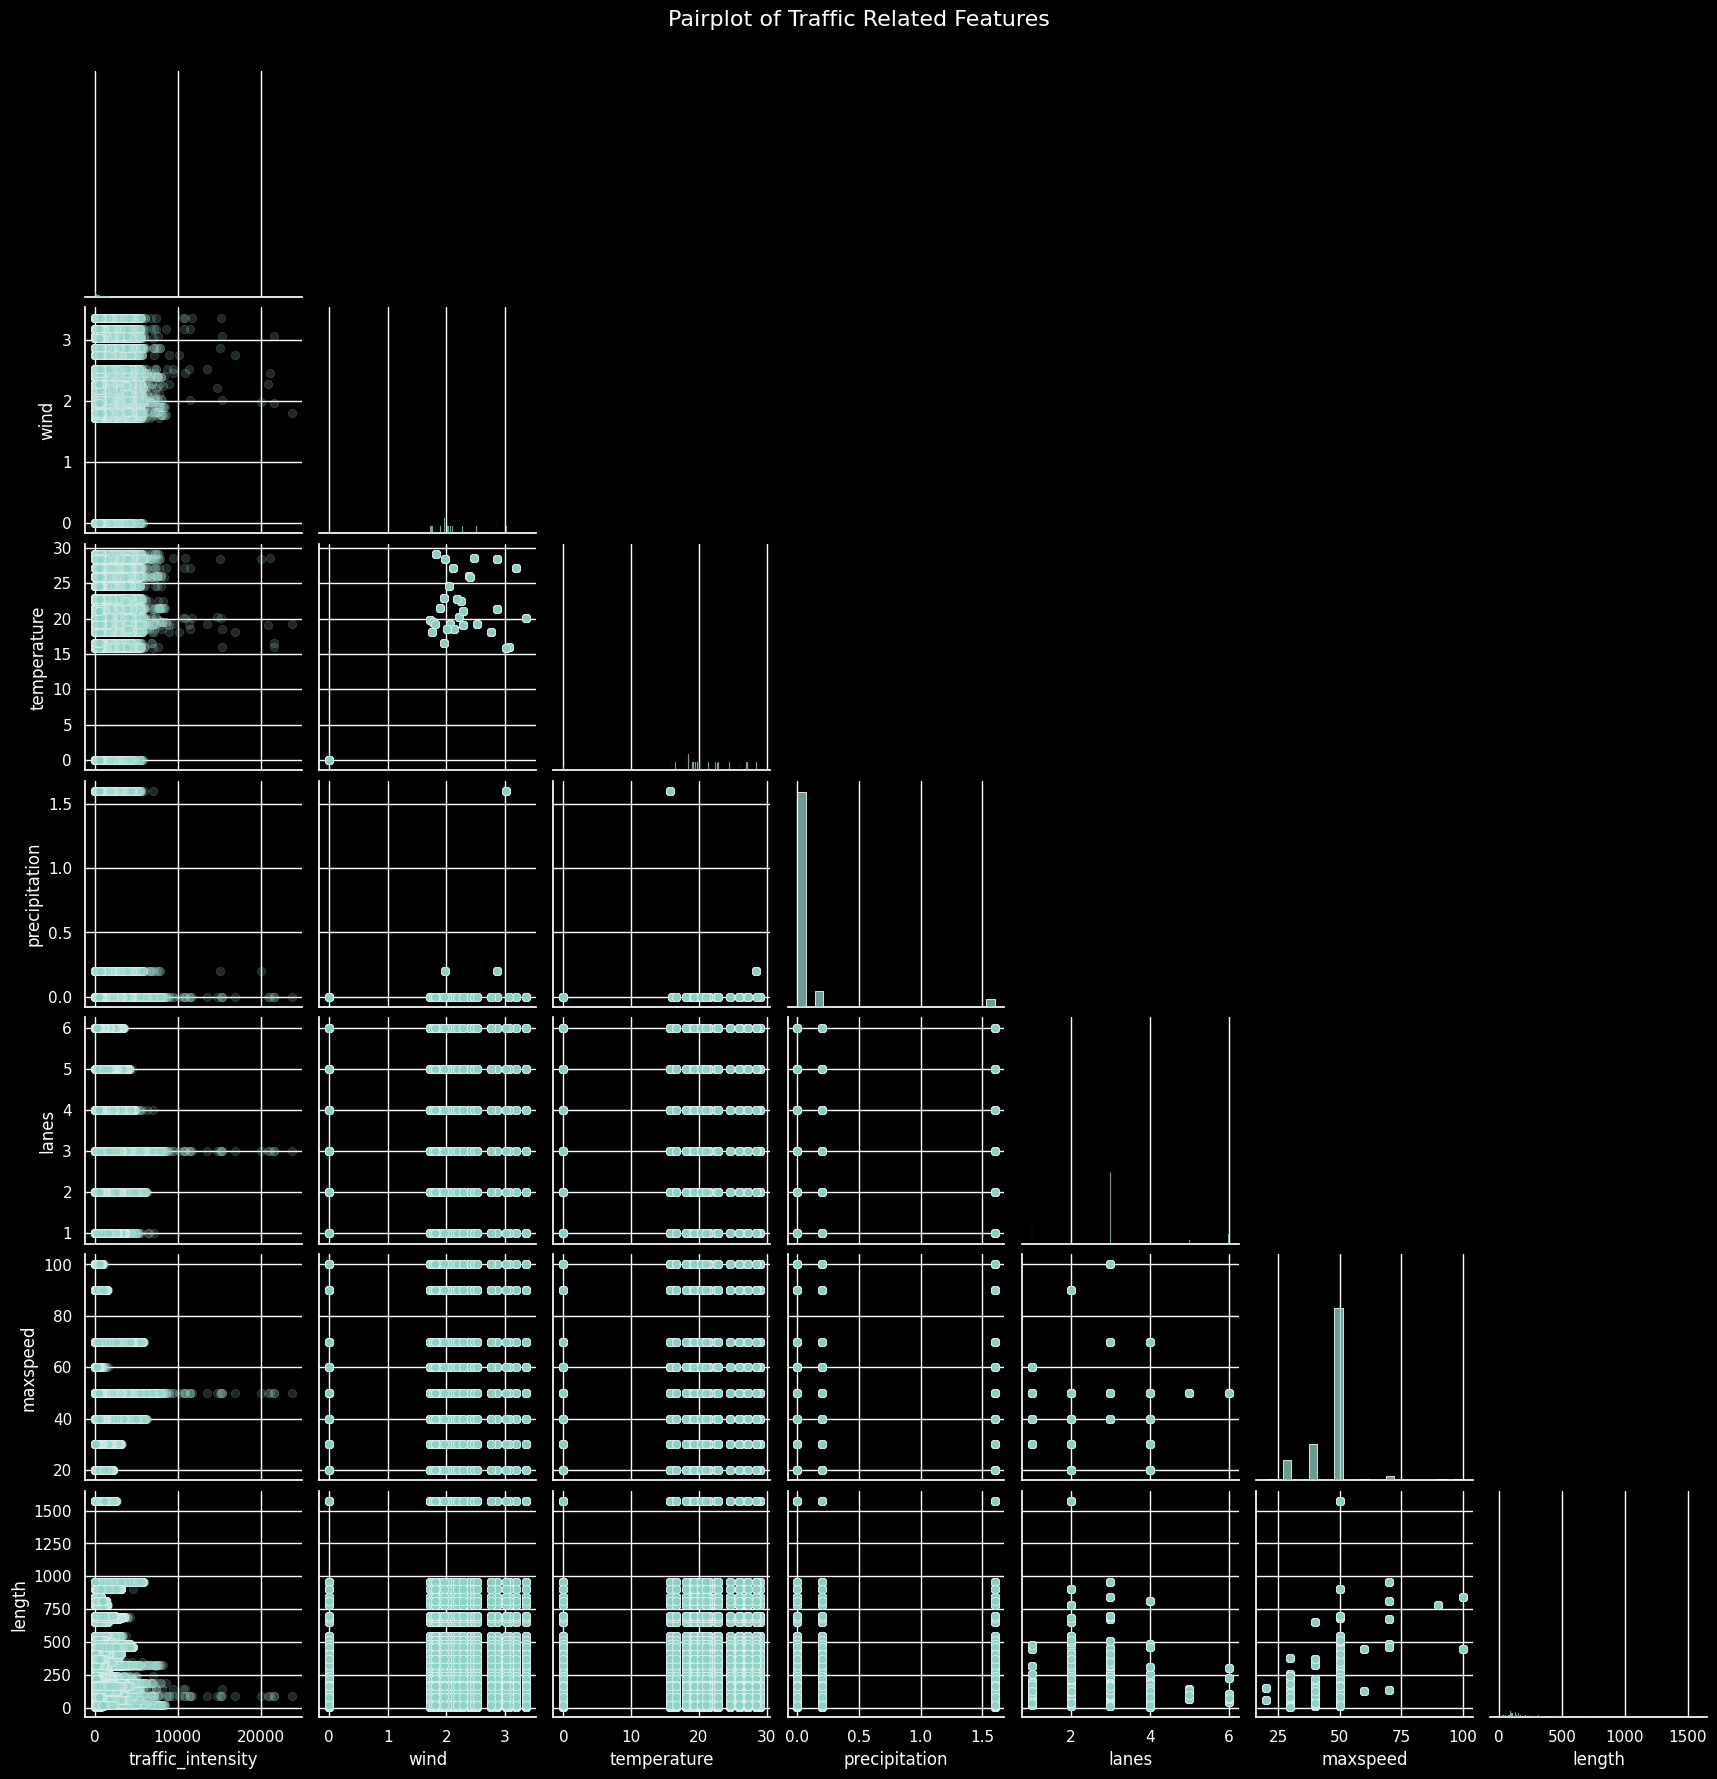

In [ ]:
# I decided to select a subset of the dataframe for pairplot analysis to make it more interpretable
features = ['traffic_intensity', 'wind', 'temperature', 'precipitation', 'lanes', 'maxspeed', 'length']
smart_data_subset = smart_data[features]

# Pairplot to see pairwise relationships and distributions
sns.set(style="darkgrid")
plt.style.use("dark_background")

sns.pairplot(smart_data_subset, corner=True, plot_kws={'alpha':0.2}, palette='bright')
plt.suptitle('Pairplot of Traffic Related Features', size=16, y=1.02)
plt.show()



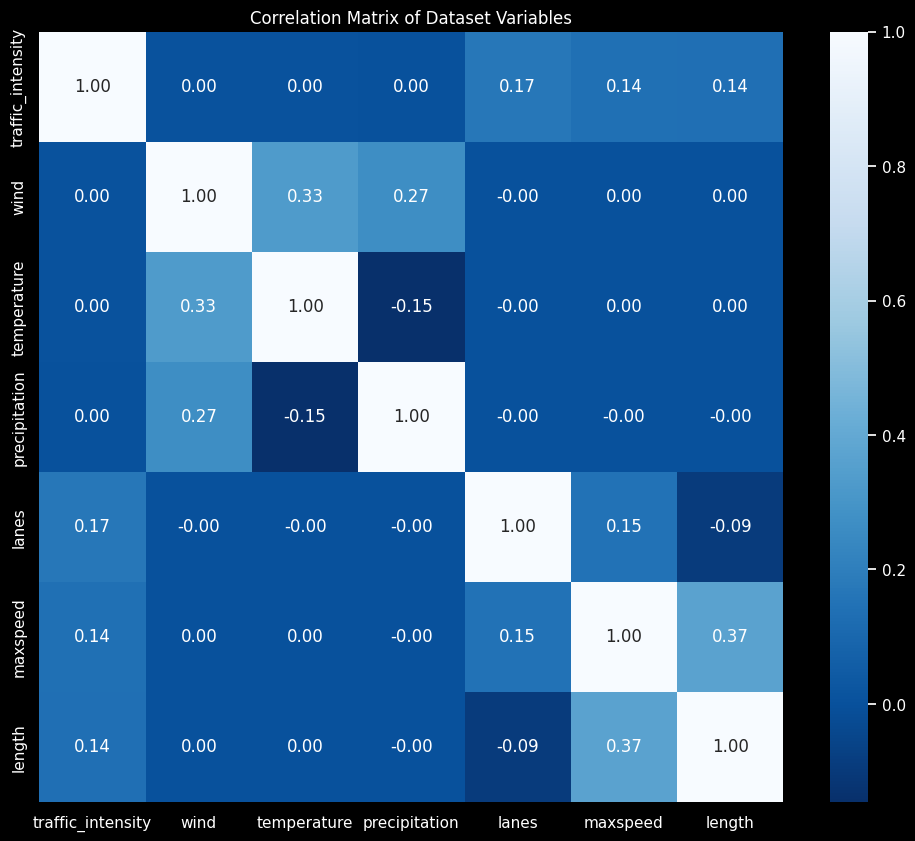

In [ ]:
# Calculating the correlation matrix
corr_matrix = smart_data_subset.corr()

# styling the plot
sns.set(style="darkgrid")
plt.style.use("dark_background")

# Generating a heatmap
plt.figure(figsize=(12, 10))
correlation_matrix_plot = sns.heatmap(corr_matrix, annot=True, cmap="Blues_r", fmt=".2f")
plt.title('Correlation Matrix of Dataset Variables')
plt.show()


## Moderate to Weak Correlations:

1. **Traffic Intensity**:
   - **Moderately correlated with lanes (0.17)**: More lanes on a road tend to have higher traffic intensity, likely due to their capacity to handle more vehicles.
   - **Slightly correlated with maxspeed and length (both 0.14)**: Roads that are longer and have higher speed limits tend to experience more traffic, suggesting they are major thoroughfares.

2. **Weather Conditions**:
   - **Wind is moderately correlated with temperature (0.33)** and slightly with precipitation (0.27): Higher temperatures often come with higher wind speeds, and increased wind speeds may be linked to wetter conditions.
   - **Temperature and precipitation have a slight negative correlation (-0.15)**: Higher temperatures typically correspond with lower precipitation levels.

3. **Road Attributes**:
   - **Lanes and maxspeed are slightly correlated (0.15)**: Roads with more lanes tend to have higher speed limits, which is typical for major highways.
   - **Maxspeed is moderately correlated with road length (0.37)**: Longer roads often allow for higher speed limits, suggesting they are designed for faster travel over longer distances.

Overall, with these correlations we can highlight how road design and environmental factors interact with traffic intensity. Our insights can guide urban planning, traffic management, and infrastructure development to improve road safety and efficiency.

-----

# **Traffic Intensity Distribution**


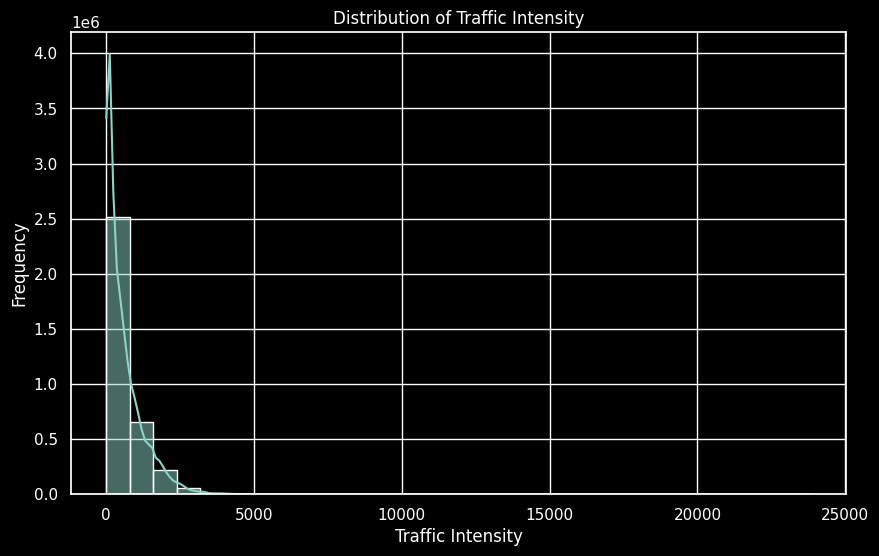

In [ ]:
# Histogram of traffic intensity
sns.set(style="darkgrid")
plt.style.use("dark_background")
plt.figure(figsize=(10, 6))
sns.histplot(smart_data['traffic_intensity'], bins=30, kde=True)
plt.title('Distribution of Traffic Intensity')
plt.xlabel('Traffic Intensity')
plt.ylabel('Frequency')
plt.show()

### **Key Observations from the Histogram**

1. **Right-Skewed Distribution**:
   - The distribution of traffic intensity is heavily right-skewed. This indicates that most of the observed traffic intensity values are low, with a few instances of very high traffic intensity.

2. **High Frequency of Low Intensity**:
   - The bulk of the data is concentrated at the lower end of the traffic intensity scale, near zero. This suggests that a large number of observations record relatively little to no traffic.

3. **Long Tail**:
   - There's a long tail extending towards the higher end of the traffic intensity scale, but it includes very few observations compared to the lower end. This demonstrates that while high traffic intensities are possible, they are rare.

4. **Data Range**:
   - Traffic intensity varies from 0 to approximately 25,000, with most data points below 5,000. The presence of data across such a wide range suggests variability in traffic conditions across different locations or times.
   --------

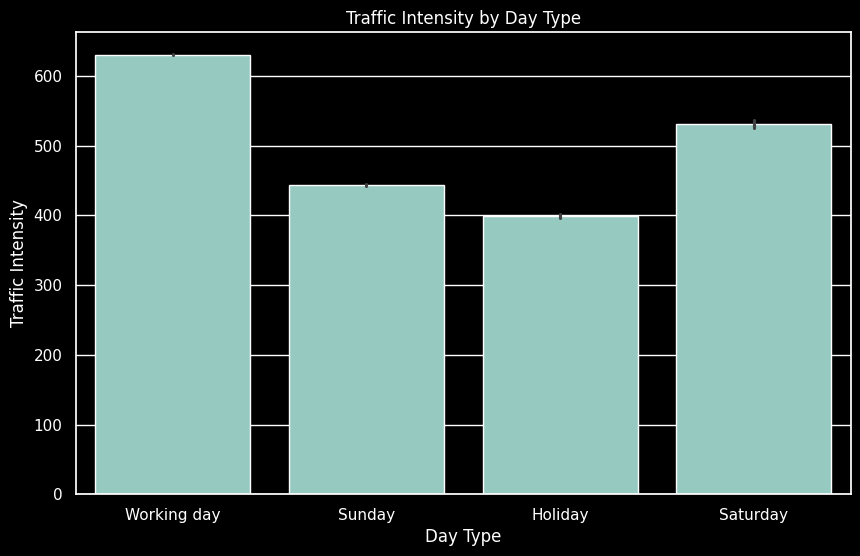

In [ ]:
# Bar plot for traffic intensity by day type
plt.figure(figsize=(10, 6))
sns.barplot(x='day_type', y='traffic_intensity', data=smart_data)

plt.title('Traffic Intensity by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Traffic Intensity')
plt.show()





### Insights

1. **Highest Traffic on Working Days**:
   - The traffic intensity is highest on working days, which is typically expected as these are the days when most people commute to work or school. This suggests that traffic management strategies should be robust on these days to handle the high volume.

2. **Comparison Between Weekend Days and Holiday**:
   - Saturdays show higher traffic intensity compared to Sundays and holidays. This might indicate that Saturdays are popular for shopping, errands, and leisure activities that lead to increased road usage.
   - Sundays and holidays have lower traffic intensity than Saturdays, which might be due to a general trend where people prefer to stay at home or engage in less commuting on these days.

3. **Slight Difference Between Sunday and Holiday**:
   - There is a slight difference in traffic intensity between Sundays and holidays, with holidays experiencing slightly lower traffic. This could be due to holidays being more uniformly observed with closures of businesses and institutions, leading to less traffic compared to regular Sundays.

-------

In [ ]:
profile = ProfileReport(
    smart_data,
    title="Pandas Profiling Report",
    minimal=True,
    missing_diagrams={
        "heatmap": False,
        "dendrogram": True
    }
)

In [ ]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---
## Time-Series Analysis Plots
* #### To analyze the traffic intensity over different times

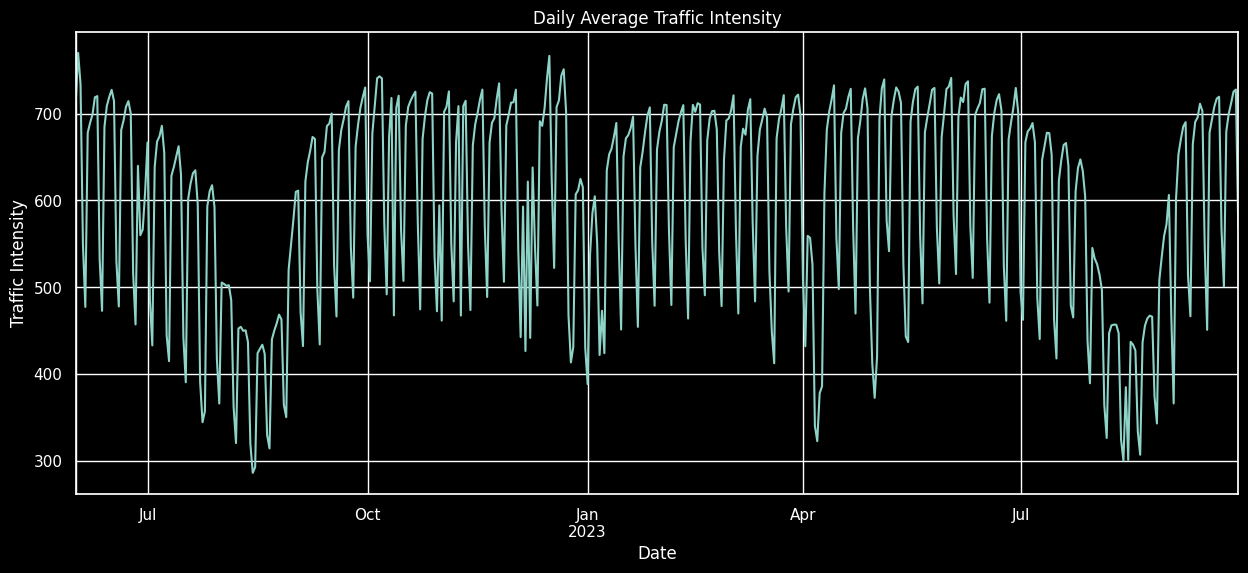

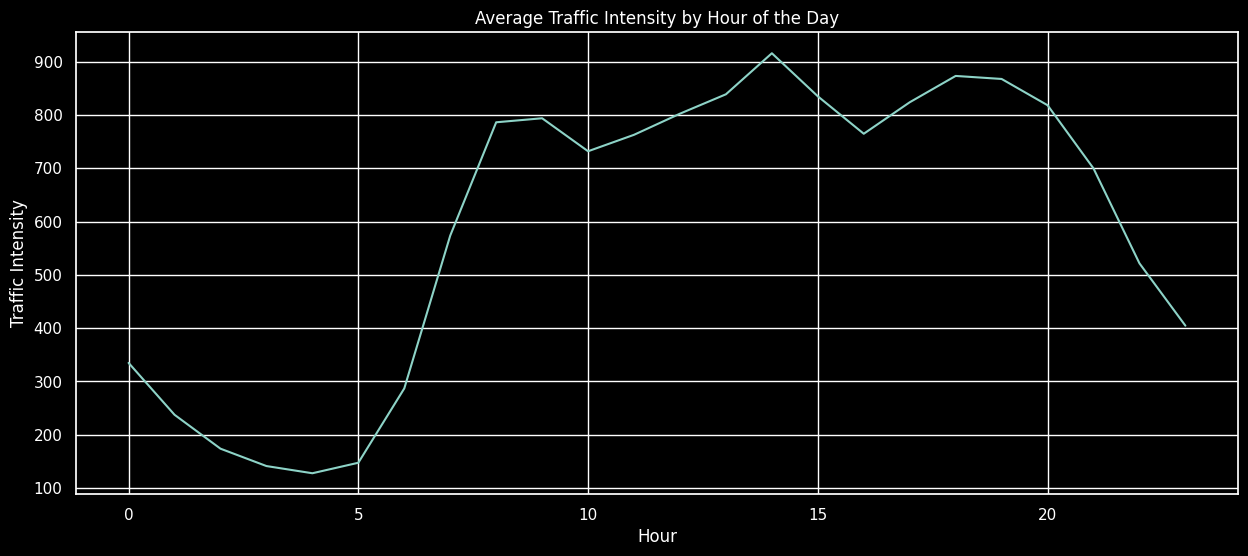

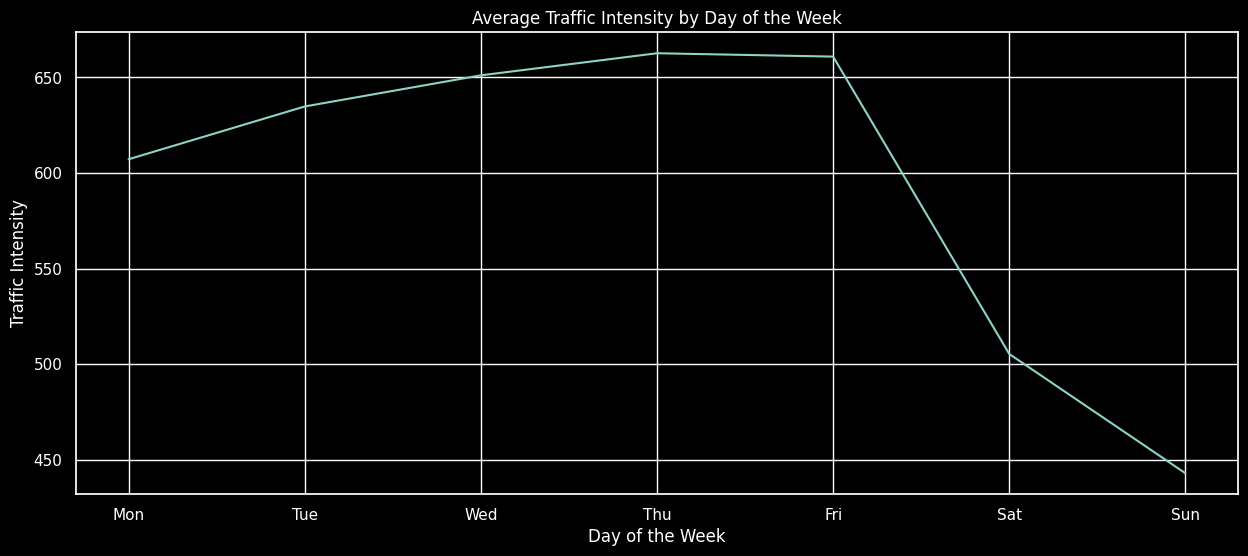

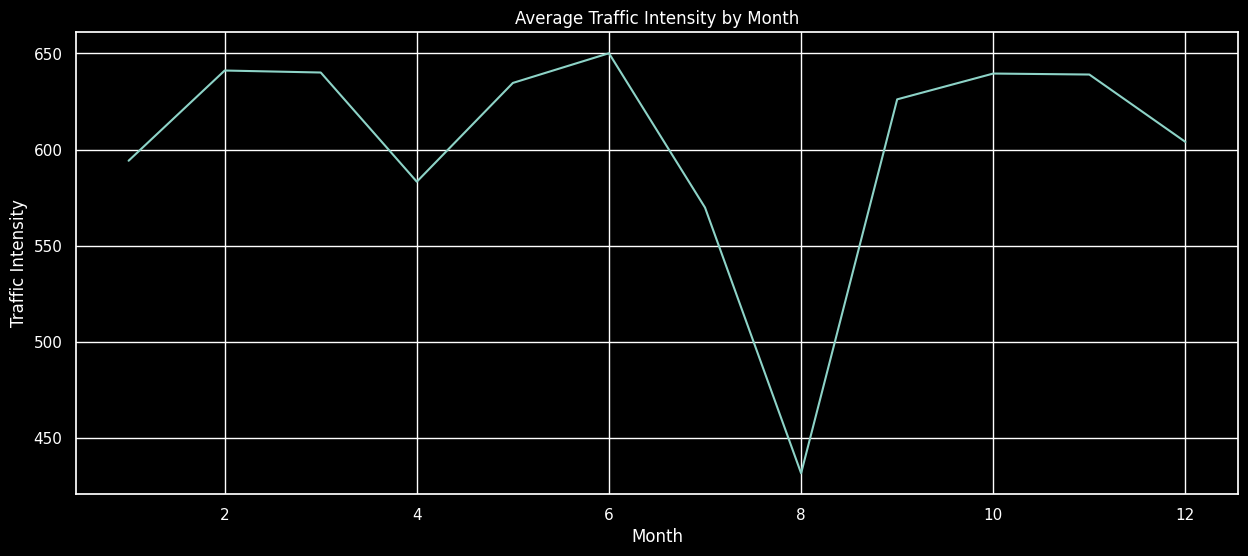

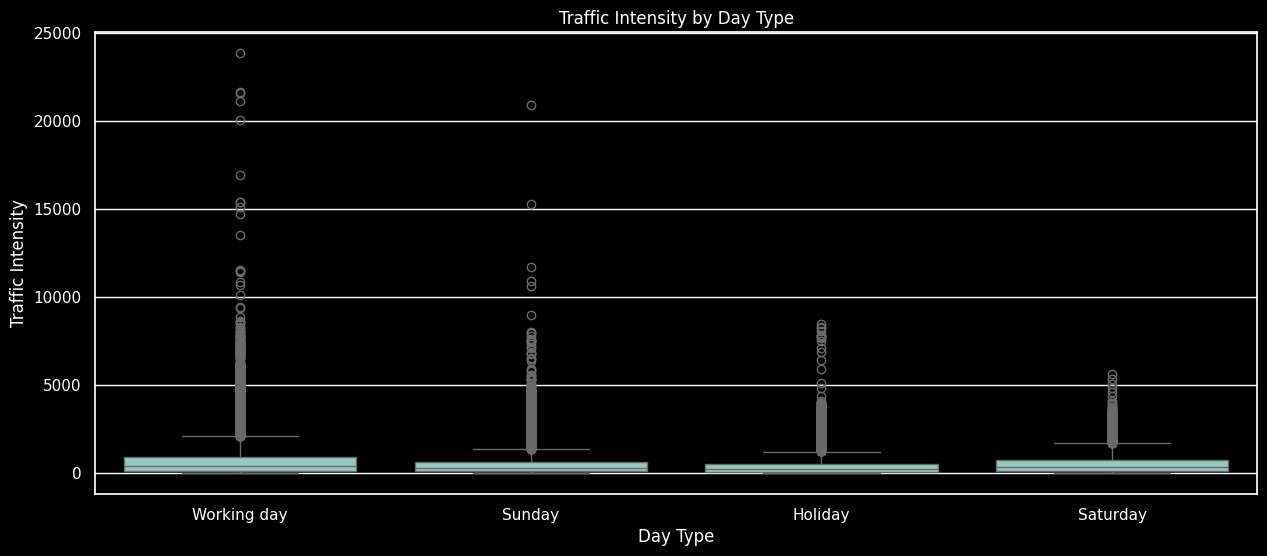

In [ ]:
## Daily average traffic intensity
smart_data['date'] = pd.to_datetime(smart_data['date'])
smart_data.set_index('date', inplace=True)


plt.figure(figsize=(15, 6))
smart_data['traffic_intensity'].resample('D').mean().plot()
plt.title('Daily Average Traffic Intensity')
plt.xlabel('Date')
plt.ylabel('Traffic Intensity')
plt.show()

## Traffic intensity by hour of the day
plt.figure(figsize=(15, 6))
smart_data.groupby(smart_data.index.hour)['traffic_intensity'].mean().plot()
plt.title('Average Traffic Intensity by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Traffic Intensity')
plt.show()

## Traffic intensity by day of the week
plt.figure(figsize=(15, 6))
smart_data.groupby(smart_data.index.dayofweek)['traffic_intensity'].mean().plot()
plt.title('Average Traffic Intensity by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Traffic Intensity')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

## Traffic intensity by month
plt.figure(figsize=(15, 6))
smart_data.groupby(smart_data.index.month)['traffic_intensity'].mean().plot()
plt.title('Average Traffic Intensity by Month')
plt.xlabel('Month')
plt.ylabel('Traffic Intensity')
plt.show()

# Boxplot to compare traffic intensity across different day types
plt.figure(figsize=(15, 6))
sns.boxplot(x='day_type', y='traffic_intensity', data=smart_data)
plt.title('Traffic Intensity by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Traffic Intensity')
plt.show()



### Key Observations:

- **Early Morning Lull**: There is a significant dip in traffic intensity during the early hours, reaching its lowest point around 5 AM. This is typical as it coincides with the time most people are asleep.

- **Morning Rush Hour**: Starting from around 5 AM, there is a sharp increase in traffic intensity, peaking between 7 AM and 9 AM. This spike likely corresponds to the morning rush hour when people are commuting to work or school.

- **Midday Plateau**: After the morning peak, traffic intensity stabilizes and maintains a relatively high level throughout the day until the evening. This plateau may indicate steady traffic due to midday activities like shopping, errands, and lunchtime outings.

- **Evening Rush Hour**: There's a second, although less sharp, peak around 4 PM to 6 PM, which can be attributed to the evening rush hour when people are returning home from work or school.

- **Sharp Decline in Evening**: Post-evening rush hour, traffic intensity sharply declines, particularly after 8 PM, suggesting that most people have returned home and fewer events or activities are taking place.

### Conclusions:

- **Peak Hours**: The traffic management systems need to be optimized for peak hours in the morning (7-9 AM) and late afternoon (4-6 PM) to handle high volumes of traffic efficiently.
- **Infrastructure Planning**: Considering these traffic patterns, infrastructure improvements such as better signaling, lane expansions, or alternative route suggestions could be beneficial during these peak times.
- **Public Transportation and Policy Making**: Encouraging the use of public transportation during peak hours through incentives might help alleviate congestion. Additionally, flexible work hours or staggered school timings could be promoted to help spread out the traffic load.

---------
### Geospatial Analysis
* Mapping the traffic sensors across Madrid to visualize traffic distribution

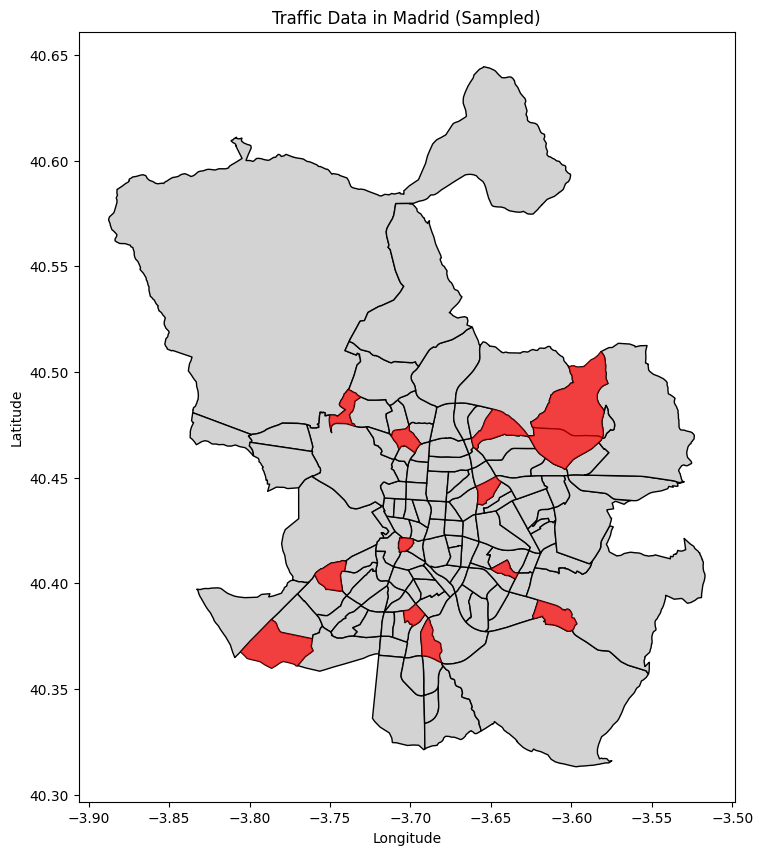

In [ ]:
madrid_map = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/smart-routes-madrid/madrid.geojson')

if madrid_map.empty:
    raise ValueError("Data not loaded properly or file is empty.")

# Sampling a fraction of the data for plotting to avoid overplotting
gdf_sample = madrid_map.sample(frac=0.10)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
madrid_map.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_sample.plot(ax=ax, markersize=5, color='red', alpha=0.7)
plt.title('Traffic Data in Madrid (Sampled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()




---


# Clustering with K-Means

In [ ]:
# Selecting 'traffic_intensity' for clustering and scale it
features = smart_data[['traffic_intensity']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
smart_data['cluster'] = kmeans.fit_predict(features_scaled)

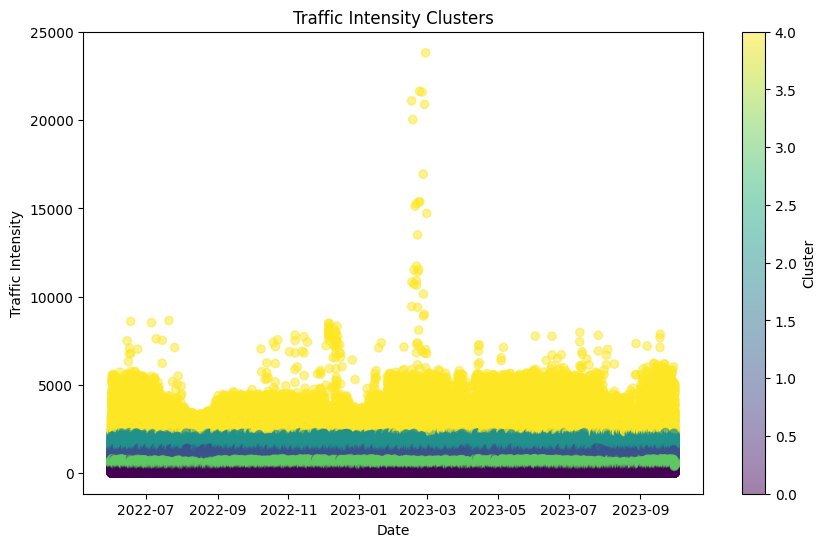

In [ ]:
# Visualizing clusters
plt.figure(figsize=(10, 6))
plt.scatter(smart_data.index, smart_data['traffic_intensity'], c=smart_data['cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Traffic Intensity Clusters')
plt.xlabel('Date')
plt.ylabel('Traffic Intensity')
plt.show()



---


## Some key insights of the Plot

 **Cluster Distribution**:
   - The plot shows a clear predominance of low to moderate traffic intensity across most of the time span. The traffic intensity is mostly concentrated in the lower cluster (dark blue and purple), which suggests these are the typical traffic conditions.
   - Higher traffic intensities (shades of green) are significantly less frequent but occur sporadically throughout the timeline. These might either represent peak traffic times or special events causing unusual traffic volumes.

**High Traffic Intensity Events**:
   - The instances of very high traffic intensity (Yellow) are few and appear as isolated spikes. These could be due to specific events or perhaps anomalies in data recording. They could also indicate times of heavy congestion that might need targeted traffic management interventions.

**Temporal Patterns**:
   - There doesn't appear to be a clear seasonal pattern visible from the clustering alone, this suggests that high traffic intensities might not be seasonally predictable. However, there's a noticeable lack of high-intensity events towards the end of the observed period, which could be of interest.

**Cluster Consistency**:
   - The majority of data points fall into two main clusters which indicate consistency in traffic patterns for lower and moderate traffic volumes. The clear separation between these clusters and the few instances of higher clusters could help in setting thresholds for traffic management strategies.



## Conclusion

  Clustering traffic intensity provides us valuable insights into traffic patterns and their variability over time. It helps in identifying typical traffic conditions and exceptional periods of high traffic. Leveraging this data, Madrid's traffic authorities can implement more informed and effective traffic management strategies.

---
# **Final Step: Machine Learning (ML)**

# **Prophet Model**

### 1. Preparing the Data:

In [ ]:
## Extracting relevant data. I created a new DataFrame with 'Date' and 'traffic_intensity' columns.
daily_traffic = smart_data.groupby('date')['traffic_intensity'].mean().reset_index()

In [ ]:
## Renaming columns since Prophet expects the time column to be named 'ds' and the value column 'y'.
daily_traffic = daily_traffic.rename(columns={'date': 'ds', 'traffic_intensity': 'y'})

In [ ]:
## Converting 'ds' to datetime:
daily_traffic['ds'] = pd.to_datetime(daily_traffic['ds'])


### 2. Creating and Fitting the Prophet Model:


In [ ]:
m = Prophet()
m.fit(daily_traffic)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0szx4ggk/u2e2vns0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0szx4ggk/ke_gwv2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81614', 'data', 'file=/tmp/tmp0szx4ggk/u2e2vns0.json', 'init=/tmp/tmp0szx4ggk/ke_gwv2b.json', 'output', 'file=/tmp/tmp0szx4ggk/prophet_model20z957eu/prophet_model-20240705233421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 3. Making Future Predictions:

In [ ]:
## Deciding how many days into the future to predict (In this case i'll do 15 days).
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)

## 4. Calculating and printing metrics:


In [ ]:
print(daily_traffic.shape)
print(forecast.tail())

(11688, 2)
                       ds       trend  yhat_lower  yhat_upper  trend_lower  \
11698 2023-10-11 23:00:00  525.643686  187.020263  576.300258   522.821557   
11699 2023-10-12 23:00:00  524.972269  205.744245  577.573908   521.554230   
11700 2023-10-13 23:00:00  524.300851  158.638028  534.922797   520.045871   
11701 2023-10-14 23:00:00  523.629433  -27.288542  353.214627   518.744065   
11702 2023-10-15 23:00:00  522.958015   41.475337  426.746447   517.078755   

       trend_upper  additive_terms  additive_terms_lower  \
11698   529.359912     -143.403517           -143.403517   
11699   529.431960     -132.609827           -132.609827   
11700   529.372547     -181.247640           -181.247640   
11701   529.743817     -358.452584           -358.452584   
11702   529.922572     -297.658000           -297.658000   

       additive_terms_upper       daily  daily_lower  daily_upper      weekly  \
11698           -143.403517 -207.234034  -207.234034  -207.234034   63.830517 

In [ ]:
y_true = daily_traffic['y'][-7:]  # Last 7 days of actual data
y_pred = forecast['yhat'][-7:]  # Last 7 days of predictions

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 401.9995393070418
Mean Squared Error: 165297.52522731086
Root Mean Squared Error: 406.56798352466325


### 5. Visualizing the Forecast:


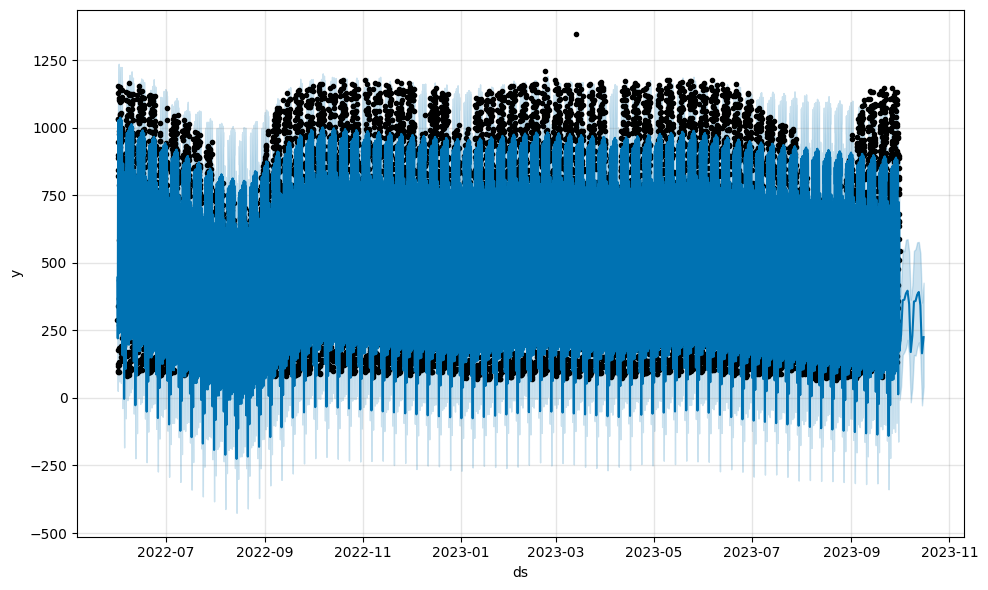

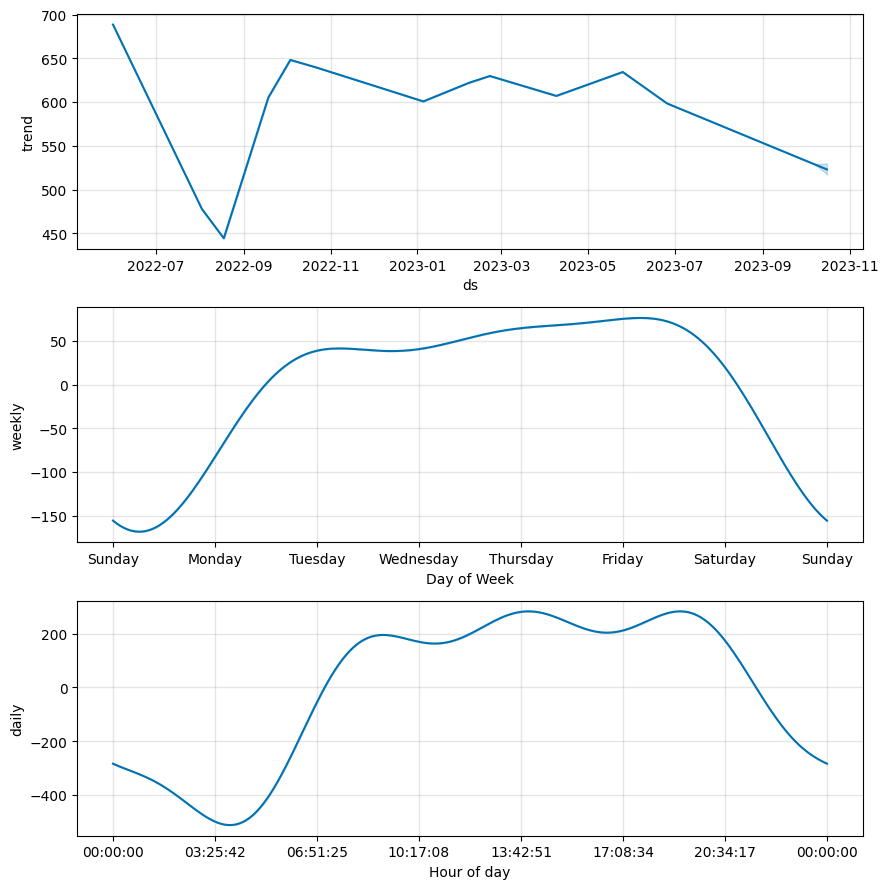

In [ ]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

## Insights from Prophet Model

1. **Trend Component (Top Plot)**:
   - **General Trend**: The trend component shows an overall flat trend with slight fluctuations over time. This indicates that the overall traffic intensity does not show a strong linear increase or decrease throughout the period from July 2022 to November 2023.

   - **Mid-Term Adjustments**: There's a noticeable dip around September 2022 followed by a recovery, suggesting a possible external impact or seasonal adjustment around this period.

2. **Weekly Seasonality (Middle Plot)**:
   - **Weekday Variation**: Traffic intensity peaks around midweek (Wednesday and Thursday), suggesting higher traffic midweek which could be due to mid-week commuting patterns or commercial activities.

   - **Weekend Drop-off**: There is a significant drop in traffic during the weekends, especially on Sunday, which is typical as weekends usually see less commuting and commercial traffic.

3. **Daily Seasonality (Bottom Plot)**:
   - **Morning Peak**: There's a strong peak around 10:00 AM, indicating heavy morning traffic, likely due to morning commutes.

   - **Evening Dip**: Traffic intensity dips in the late evening, around 20:30, which could be attributed to the conclusion of typical business hours and less commuting.

## Conclusions Based on Error Metrics

- **Mean Absolute Error (MAE) of 401.999**: This suggests that on average, the model's predictions are about 402 units off from the actual traffic intensity values. Given the range of traffic intensity we observed in the trend plot, this error represents a moderate deviation, impacting the model's precision for finer traffic management applications.
  
- **Mean Squared Error (MSE) of 165297.525**: The MSE is quite high, which emphasizes that there are significant variations in the model's predictions when compared to actual values, particularly penalizing larger errors.

- **Root Mean Squared Error (RMSE) of 406.568**: Similar to the MAE, the RMSE provides us another measure of average error magnitude, and being relatively close in value to the MAE suggests a consistent error variance without extreme outliers.

### Improvements I could do in a future

1. **Model Tuning**: Consider tuning the model by adjusting seasonality parameters and potentially incorporating additional regressors that could help explain some of the variations, such as public events or specific traffic policies enacted within certain periods.

2. **Data Quality and Additional Variables**: Investigate the quality of the input data and consider including additional variables such as school holidays, public holidays, or any construction work information that could impact traffic flow.

3. **Hybrid Models**: Given the complexity of urban traffic patterns, consider hybrid models that might combine Prophet with machine learning approaches to account for non-linear interactions and anomalies better.

4. **Anomaly Detection**: Implement anomaly detection mechanisms to identify and adjust for unusual traffic patterns, which may help in improving overall model accuracy.



---


# **Autoregressive Integrated Moving Average (ARIMA) Model**

### Fit ARIMA Model


In [ ]:
model_arima = ARIMA(daily_traffic['y'], order=(5, 1, 0))
model_arima_fit = model_arima.fit()
forecast_period = 30
predictions_arima = model_arima_fit.forecast(steps=forecast_period)


In [ ]:
y_true_arima = daily_traffic['y'][-forecast_period:]


## Calculating and printing metrics:


In [ ]:
mae_arima = mean_absolute_error(y_true_arima, predictions_arima)
mse_arima = mean_squared_error(y_true_arima, predictions_arima)
rmse_arima = mean_squared_error(y_true_arima, predictions_arima, squared=False)
print('ARIMA - Mean Absolute Error:', mae_arima)
print('ARIMA - Mean Squared Error:', mse_arima)
print('ARIMA - Root Mean Squared Error:', rmse_arima)

ARIMA - Mean Absolute Error: 210.60829760526207
ARIMA - Mean Squared Error: 59601.90044105509
ARIMA - Root Mean Squared Error: 244.13500453858535


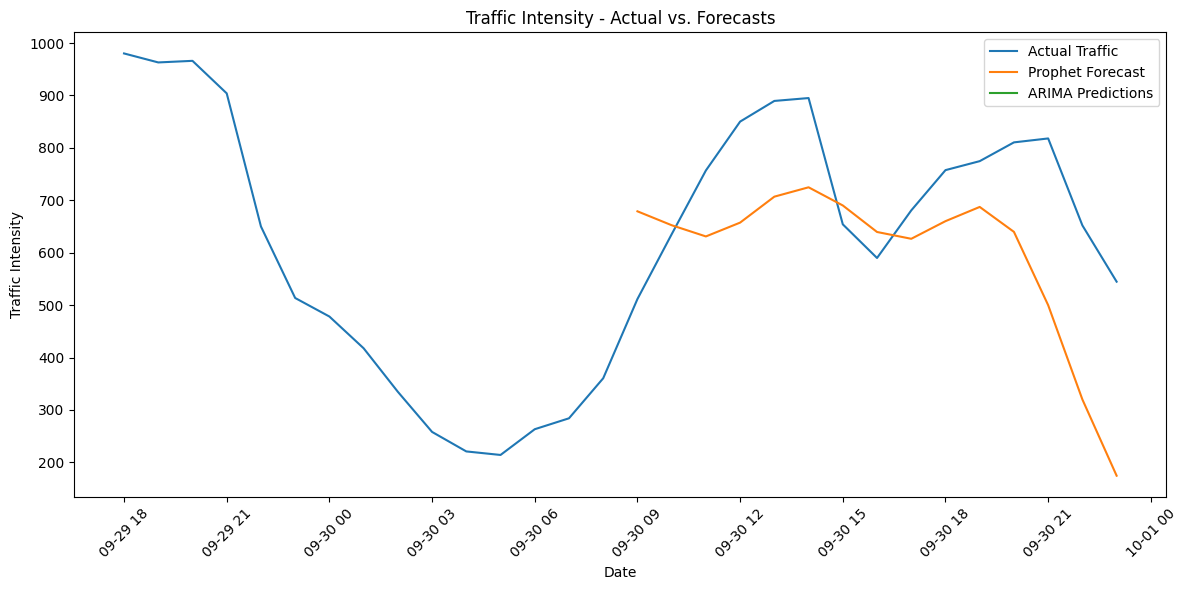

In [ ]:
last_15_days = daily_traffic['ds'][-forecast_period:]
actual_values = daily_traffic['y'][-forecast_period:]
prophet_predictions = forecast['yhat'][-forecast_period:]
arima_predictions = predictions_arima

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=last_15_days, y=actual_values, label='Actual Traffic')
sns.lineplot(x=last_15_days, y=prophet_predictions, label='Prophet Forecast')
sns.lineplot(x=last_15_days, y=arima_predictions, label='ARIMA Predictions')

plt.title('Traffic Intensity - Actual vs. Forecasts')
plt.xlabel('Date')
plt.ylabel('Traffic Intensity')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Insights of ARIMA model

1. **Trend and Volatility**: The actual traffic intensity data (blue line) shows significant volatility over the analyzed period. It demonstrates a sharp decline in the early days, a substantial recovery, and then a fluctuating but generally upward trend until a sharp drop at the end of the period.

2. **ARIMA Predictions (Orange Line)**:
   - **General Trend Matching**: The model appears to follow the overall trend reasonably well up until the last sharp decline. It captures some of the major shifts in traffic intensity, particularly the mid-period peak and subsequent falls.
   - **Lagging Peaks and Troughs**: The model seems to lag slightly behind the actual data in terms of peaks and troughs.
   - **End of Period Miss**: This model didn't anticipate the sharp decline in traffic intensity at the end of the period, suggesting limitations in its ability to predict sudden changes or external shocks.

### Error Metrics Analysis

- **Mean Absolute Error (MAE) of 210.61**: This metric indicates that, on average, the ARIMA model's predictions are about 210 units off from the actual values. Considering the scale of traffic intensity (which ranges up to 900), this error size is moderate but still significant for practical applications such as traffic management where precision can be crucial.

- **Mean Squared Error (MSE) of 59601.9** and **Root Mean Squared Error (RMSE) of 244.14**: These confirm that the model has substantial errors, particularly where it fails to predict sharp rises or drops.

### Conclusions and Recommendations

- **Model Limitations**: The ARIMA model's performance, while decent in capturing general trends, shows limitations in reacting to quick shifts in traffic patterns. This might be due to the inherent nature of ARIMA models which rely on past data and general differencing, moving average, and autoregressive components, which might not be sufficient to model complex or sudden changes driven by external factors.